# 실제 학습 코드 (7epoch)
- model : vanila trocr
- processor : vanila trocr
- tokenizer : team-lucid/trocr-small-korean의 토크나이저 (RobertaTokenizerFast)

In [40]:
import pandas as pd
df = pd.read_csv('halfdata/cropped_image_half.csv')
df

,original_img_name,text,bbox,bbox 높이에 대한 너비 비,text_length,file_name
0,medicine_31215.jpg,건강,"[270.7996407778658, 181.6060866848643, 85.8899...",1.729167,2,medicine_31215_0.jpg
1,medicine_31215.jpg,기능식품,"[231.2671741729349, 237.28789101405005, 163.89...",3.250000,4,medicine_31215_1.jpg
2,medicine_31215.jpg,MADE,"[2084.202921282695, 176.46746671166335, 243.71...",3.909091,4,medicine_31215_2.jpg
3,medicine_31215.jpg,IN,"[2334.8476798738207, 183.39483441141803, 98.24...",1.677419,2,medicine_31215_3.jpg
4,medicine_31215.jpg,USA,"[2444.426041669941, 185.91387721132884, 150.51...",2.366337,3,medicine_31215_4.jpg
...,...,...,...,...,...,...
50995,medicine_32162.jpg,"plantarum,","[1025.4162565427919, 666.2598973080914, 286.08...",4.068966,10,medicine_32162_12.jpg
50996,medicine_32162.jpg,"paracasei,","[1676.3878095347584, 665.0476597792422, 259.41...",3.754386,10,medicine_32162_13.jpg
50997,medicine_32162.jpg,Streptococ-,"[1949.1412535258057, 665.0476597792422, 311.54...",5.586957,11,medicine_32162_14.jpg
50998,medicine_32162.jpg,cus,"[134.4216728387039, 747.479811740981, 94.55452...",1.950000,3,medicine_32162_15.jpg


In [42]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2)
# we reset the indices to start from zero
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

## 토크나이저 불러오기

In [43]:
from transformers import VisionEncoderDecoderModel, AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("team-lucid/trocr-small-korean")
tokenizer

RobertaTokenizerFast(name_or_path='team-lucid/trocr-small-korean', vocab_size=50265, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	50264: AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False, special=True),
}

In [44]:
import torch
from torch.utils.data import Dataset
from PIL import Image

class IAMDataset(Dataset):
    def __init__(self, root_dir, df, processor, tokenizer,max_target_length=32): # max_target_length 낮출 필요 있음.max(df['text length']) 찍어보기
        self.root_dir = root_dir
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # get file name + text
        file_name = self.df['file_name'][idx]
        text = self.df['text'][idx]
        # prepare image (i.e. resize + normalize)
        image = Image.open(self.root_dir + file_name).convert("RGB")
        pixel_values = self.processor(image, return_tensors="pt").pixel_values
        # add labels (input_ids) by encoding the text
        # labels = self.processor.tokenizer(text,
        #                                   padding="max_length",
        #                                   max_length=self.max_target_length).input_ids
        labels = self.tokenizer(text, padding="max_length", 
                                # stride=32,
                                truncation=True,
                                max_length=self.max_target_length).input_ids
        
        # important: make sure that PAD tokens are ignored by the loss function
        # labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]
        labels = [label if label != self.tokenizer.pad_token_id else -100 for label in labels]

        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding

In [45]:
from transformers import TrOCRProcessor, AutoTokenizer
# model = VisionEncoderDecoderModel.from_pretrained("team-lucid/trocr-small-korean")
processor = TrOCRProcessor.from_pretrained('microsoft/trocr-small-printed')
train_dataset = IAMDataset(root_dir='halfdata/cropped_image_half/',
                           df=train_df,
                           tokenizer=tokenizer,
                           processor=processor)
eval_dataset = IAMDataset(root_dir='halfdata/cropped_image_half/',
                           df=test_df,
                           tokenizer=tokenizer,
                           processor=processor)

print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(eval_dataset))

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


Number of training examples: 40800
Number of validation examples: 10200


In [46]:
encoding = train_dataset[0]
for k,v in encoding.items():
  print(k, v.shape)

pixel_values torch.Size([3, 384, 384])
labels torch.Size([32])


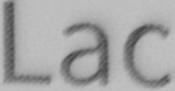

In [47]:
image = Image.open(train_dataset.root_dir + train_df['file_name'][0]).convert("RGB")
image

In [48]:
labels = encoding['labels']
labels[labels == -100] = tokenizer.pad_token_id
label_str = tokenizer.decode(labels, skip_special_tokens=True)
# labels[labels == -100] = processor.tokenizer.pad_token_id
# label_str = processor.decode(labels, skip_special_tokens=True)
print(label_str)

Lac


In [49]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
eval_dataloader = DataLoader(eval_dataset, batch_size=4)

# Train model

In [50]:
torch.cuda.is_available()

True

In [51]:
from transformers import VisionEncoderDecoderModel
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = VisionEncoderDecoderModel.from_pretrained('model') #모델 pt가 있는 폴더경로를 알려주면 됨.
model.to(device)

VisionEncoderDecoderModel(
  (encoder): DeiTModel(
    (embeddings): DeiTEmbeddings(
      (patch_embeddings): DeiTPatchEmbeddings(
        (projection): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): DeiTEncoder(
      (layer): ModuleList(
        (0-11): 12 x DeiTLayer(
          (attention): DeiTAttention(
            (attention): DeiTSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): DeiTSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): DeiTIntermediate(
            (dense): Linear(

In [52]:
model.config.decoder_start_token_id = tokenizer.cls_token_id
model.config.pad_token_id = tokenizer.pad_token_id
model.config.vocab_size = model.config.decoder.vocab_size

# set beam search parameters
model.config.eos_token_id = tokenizer.sep_token_id


# set special tokens used for creating the decoder_input_ids from the labels
# model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
# model.config.pad_token_id = processor.tokenizer.pad_token_id
# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size

# set beam search parameters
# model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = 64
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

In [ ]:
!pip install datasets jiwer

In [53]:
from datasets import load_metric
cer_metric = load_metric("cer")

/home/wooju/anaconda3/envs/py39_trocr/lib/python3.9/site-packages/datasets/load.py:756: FutureWarning: The repository for cer contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/cer/cer.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [54]:
def compute_cer(pred_ids, label_ids):

    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    label_ids[label_ids == -100] = processor.tokenizer.pad_token_id
    label_str = tokenizer.batch_decode(label_ids, skip_special_tokens=True)

    # 빈문자열 제거 # 왜 아무도 안알려주냐고
    pred_str = [pred_str[i] for i in range(len(pred_str)) if len(label_str[i]) > 0]
    label_str = [label_str[i] for i in range(len(label_str)) if len(label_str[i]) > 0]

    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return cer

In [55]:
from transformers import AdamW
from tqdm.notebook import tqdm
import csv

optimizer = AdamW(model.parameters(), lr=5e-5)

for epoch in range(4,7):  # loop over the dataset multiple times
   # train
  model.train()
  train_loss = 0.0
  for batch in tqdm(train_dataloader):
    # get the inputs
    for k,v in batch.items():
      batch[k] = v.to(device)

    # forward + backward + optimize
    outputs = model(**batch)
    loss = outputs.loss
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    train_loss += loss.item()

  print(f"Loss after epoch {epoch}:", train_loss/len(train_dataloader))

   # evaluate
  model.eval()
  valid_cer = 0.0
  with torch.no_grad():
    for batch in tqdm(eval_dataloader):
      # run batch generation
      outputs = model.generate(batch["pixel_values"].to(device))
      # compute metrics
      cer = compute_cer(pred_ids=outputs, label_ids=batch["labels"])
      valid_cer += cer

  print("Validation CER:", valid_cer / len(eval_dataloader))


  with open('trainresult.csv', 'a') as f:
    data = [{'epoch': epoch, 'loss': train_loss/len(train_dataloader), 'Validation CER':  valid_cer / len(eval_dataloader) }]
    writer = csv.DictWriter(f, fieldnames=data[0].keys()) # fieldnames=['Name', 'Height']
    if epoch == 0:
        writer.writeheader()  # 첫 번째 루프에서만 헤더 쓰기
    writer.writerows(data)

  model.save_pretrained("./model/")

/home/wooju/anaconda3/envs/py39_trocr/lib/python3.9/site-packages/transformers/optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/10200 [00:00<?, ?it/s]

Loss after epoch 4: 0.38803601636809404


  0%|          | 0/2550 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 64, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}


Validation CER: 0.12408556682878534


  0%|          | 0/10200 [00:00<?, ?it/s]

Loss after epoch 5: 0.2918694868942622


  0%|          | 0/2550 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 64, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}


Validation CER: 0.1103732389453185


  0%|          | 0/10200 [00:00<?, ?it/s]

Loss after epoch 6: 0.22914171106580272


  0%|          | 0/2550 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 64, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}


Validation CER: 0.10557820137243855


# Inference

In [27]:
df = pd.read_csv('data/cropped_image.csv')
df_infer = df.iloc[60000:]
df_infer

,original_img_name,text,bbox,bbox 높이에 대한 너비 비,text_length,file_name
60000,medicine_32275.jpg,및,"[2063.549032545688, 721.9072080204544, 45.0854...",0.700000,1,medicine_32275_32.jpg
60001,medicine_32275.jpg,[원료명,"[1878.9132963780062, 713.3194993614924, 163.16...",2.268657,4,medicine_32275_33.jpg
60002,medicine_32275.jpg,"옥수수전분],","[1976.9988783403421, 792.6044345922198, 266.49...",3.297653,7,medicine_32275_34.jpg
60003,medicine_32275.jpg,"DL-트레오닌),","[1542.9191950961197, 860.3840101462162, 326.33...",4.222222,9,medicine_32275_35.jpg
60004,medicine_32275.jpg,"말토덱스트린,","[1584.7842748085595, 937.6733880768736, 322.03...",4.347826,7,medicine_32275_36.jpg
...,...,...,...,...,...,...
102002,medicine_32820.jpg,유통기한,"[109.49328779974199, 3030.854831940932, 337.68...",2.941489,4,medicine_32820_97.jpg
102003,medicine_32820.jpg,나트륨,"[1288.428836456075, 906.5898020406504, 276.353...",2.428571,3,medicine_32820_98.jpg
102004,medicine_32820.jpg,"25㎍(1,000","[1039.4533106824476, 1015.1929759969929, 528.3...",4.055687,9,medicine_32820_99.jpg
102005,medicine_32820.jpg,까지,"[1454.0794263845135, 3021.2979179264426, 182.4...",1.565934,2,medicine_32820_100.jpg


In [ ]:
import os
from PIL import Image
from transformers import VisionEncoderDecoderModel, AutoTokenizer, TrOCRProcessor
import torch
import pandas as pd
import csv

df = pd.read_csv('data/cropped_image.csv')
df_infer = df.iloc[68120:]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VisionEncoderDecoderModel.from_pretrained('./model')
model.to(device)

processor = TrOCRProcessor.from_pretrained('microsoft/trocr-small-printed')
tokenizer = AutoTokenizer.from_pretrained("team-lucid/trocr-small-korean")
# processor = TrOCRProcessor.from_pretrained('./model')
# tokenizer=AutoTokenizer.from_pretrained('./model')
 
for idx, data in df_infer.iterrows():
    image_folder = 'data/croppedimages'
    original_label = data['text']

    image = Image.open(os.path.join(image_folder, data['file_name'])).convert('RGB')
    pixel_values = processor(image,return_tensors='pt').pixel_values
    
    generated_ids = model.generate(pixel_values.to(device))
    generated_text = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
    
    # print('Decoded label = {},{}'.format(original_label,generated_text))

    with open('inferenceresult.csv', 'a') as f:
        info = [{'file_name': data['file_name'], 'original_label': original_label, 'generated_text':  generated_text }]
        writer = csv.DictWriter(f, fieldnames=info[0].keys()) # fieldnames=['Name', 'Height']
        # if  data['file_name'] == "medicine_32275_32.jpg":
        #     writer.writeheader()  # 첫 번째 루프에서만 헤더 쓰기
        writer.writerows(info)
    

In [38]:
import pandas as pd
result = pd.read_csv('inferenceresult.csv')
result

same = 0
dif = 0

for idx, data in result.iterrows():
    if data['original_label'] == data['generated_text'] :
        same += 1

    else :
        dif += 1
print(f"{len(result)}개 중 정확히 일치하는 데이터 수 : {same}, 다른 데이터 수 : {dif}")

42007개 중 정확히 일치하는 데이터 수 : 34739, 다른 데이터 수 : 7268
